# Assignment 1

This is an individual assignment, but you may collaborate with team mates on getting to know the data. 

## The dataset

Consider the cps-earnings dataset  at https://osf.io/g8p9j/ (Cross section. N=149 316 individuals)

Pick an occupation and filter data accordingly. You must all pick different occupations / occupation individually.  
Occupation codes are here: https://osf.io/57n9q/
You may merge occupations as you see fit (ie all tax/insurance specialists, etc). 
You can see some ideas working with this code here.

https://github.com/gabors-data-analysis/da_case_studies/tree/master/ch09-gender-age-earnings
https://github.com/gabors-data-analysis/da_case_studies/tree/master/ch10-gender-earnings-understand
## Tasks

Build four predictive models using linear regression for earnings per hour. 

1. Models: the target variable is earnings per hour, all others would be predictors.
2. Model 1 shall be the simplest, model 4 the more complex. It shall be OLS. You shall explain your choice of predictors.
3. Compare model performance of these models (a) RMSE in the full sample, (2) cross-validated RMSE and (c) BIC in the full sample. 
4. Discuss the relationship between model complexity and performance. You may use visual aids. 
5. You should submit your code in Github and 1 page report in pdf on Moodle. 

Work individually. But you may collaborate in your support group, check and comment (add issues) on each other code.

## Hints re Git and commit

Committing is a habit, and people may have different ways. 

Some people commit very frequently, others less so. 
We basically expect you to have a few commits, one per major parts of the exercise. The first commit will set up the the folder/file for A1. 
Then you can commit, say data work, descriptives, graphics, and regressions. And then, commit your edits. 
Make sure the commit text is short but meaningful: Good: "adding graphs", "calculate RMSE", "edit typos". Bad: "update"
Grading

This assignment is worth 20 points. 

* 5 points will be for Git use. 
* 10 points will be technical aspects the analysis 
* 5 points will be based on your report

### Setting up directories and import packages

In [1]:
### SETTING UP DIRECTORIES

# import packages
import pandas as pd
import os
import numpy as np
import sys
import warnings

from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mizani import transforms
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess
import seaborn as sns
from mizani.formatters import percent_format
import regex as re

warnings.filterwarnings("ignore")

# set working directory for da_data_repo -- replace the
os.chdir('C:\\Users\\77774\\Documents\\GitHub\\Prediction_with_ML_for_Economists\\Assignment_1_cps_earnings_dataset')

# location folders
data_in = "C:\\Users\\77774\\Documents\\GitHub\\Prediction_with_ML_for_Economists\\Assignment_1_cps_earnings_dataset\\clean\\"
data_out = "C:\\Users\\77774\\Documents\\GitHub\\Prediction_with_ML_for_Economists\\Assignment_1_cps_earnings_dataset\\clean\\"
results = "C:\\Users\\77774\\Documents\\GitHub\\Prediction_with_ML_for_Economists\\Assignment_1_cps_earnings_dataset\\results\\"

In [2]:
# load dataset (as unicode, to avoid size and memor warnings)

df = pd.read_csv(
    data_in + "morg-2014-emp.csv",
    quotechar='"',
    delimiter=",",
    encoding="utf-8",
#    dtype = "unicode"
)

### Prepare data

In [3]:
# Keep only financial specialists

df.loc[
    ((df["occ2012"] >= 800) & (df["occ2012"] <= 950)), "sample"
] = 1
df.loc[df["sample"].isna(), "sample"] = 0

df = df.loc[
    (df["sample"] == 1), :
].reset_index(drop=True)

In [4]:
#create some variables

#female
df["female"] = (df.sex == 2).astype(int)

#w and lnw
df["w"] = df["earnwke"] / df["uhours"]
df["lnw"] = np.log(df["w"])

#age forms
df["agesq"] = np.power(df["age"], 2)
df["agecu"] = np.power(df["age"], 3)

#married
df['married'] = (df.marital <= 4).astype(int)

#race
df["white"] = (df["race"] == 1).astype(int)
df["afram"] = (df["race"] == 2).astype(int)
df["asian"] = (df["race"] == 4).astype(int)
df["hisp"] = (df["ethnic"].notna()).astype(int)
df["othernonw"] = (
    (df["white"] == 0) & (df["afram"] == 0) & (df["asian"] == 0) & (df["hisp"] == 0)
).astype(int)

#nonUSborn
df["nonUSborn"] = (
    (df["prcitshp"] == "Foreign Born, US Cit By Naturalization")
    | (df["prcitshp"] == "Foreign Born, Not a US Citizen")
).astype(int)

#havechild = at least 1 child
df['havechild']=(df['chldpres']>0).astype(int)

In [5]:
# transform grade92 to educ (which will be measured in years)
# create a list of our conditions
conditions = [
    (df['grade92'] == 31),
    (df['grade92'] == 32),
    (df['grade92'] == 33),
    (df['grade92'] == 34),
    (df['grade92'] == 35),
    (df['grade92'] == 36),
    (df['grade92'] == 37),
    (df['grade92'] == 38),
    (df['grade92'] == 39),
    (df['grade92'] == 40),
    (df['grade92'] == 41),
    (df['grade92'] == 42),
    (df['grade92'] == 43),
    (df['grade92'] == 44),
    (df['grade92'] == 45),
    (df['grade92'] == 46)
    ]

# create a list of the values we want to assign for each condition
values = [1, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 15, 16, 18, 18, 20]

# create a new column and use np.select to assign values to it using our lists as arguments
df['educ'] = np.select(conditions, values)
df['educsq'] = np.power(df["educ"], 2)
df['educcu'] = np.power(df["educ"], 3)


In [6]:
# remove columns we don't need
df= df[
    [

'earnwke' ,
'uhours'   ,     
'age'      ,            
'occ2012'   ,        
'female'    ,     
'w'         ,   
'lnw'     ,     
'agesq'     ,   
'agecu'    ,         
'married'   ,     
'white'      ,    
'afram'       ,   
'asian'        ,  
'hisp'          , 
'othernonw'      ,
'nonUSborn'      ,
'havechild'      ,
'educ'           ,
'educsq'         ,
'educcu'        
    ]
]

### Look at the data

In [7]:
#quick look
df.describe()

,earnwke,uhours,age,occ2012,female,w,lnw,agesq,agecu,married,white,afram,asian,hisp,othernonw,nonUSborn,havechild,educ,educsq,educcu
count,3404.000000,3404.000000,3404.000000,3404.000000,3404.000000,3404.000000,3404.000000,3404.000000,3404.000000,3404.000000,3404.000000,3404.000000,3404.000000,3404.000000,3404.000000,3404.000000,3404.000000,3404.000000,3404.000000,3404.000000
mean,1252.053637,41.211222,42.066392,834.030552,0.603702,30.335379,3.267568,1902.685076,91328.103995,0.642186,0.826381,0.074912,0.080787,0.065805,0.014982,0.123090,0.395417,15.814630,252.328731,4058.219448
std,685.573216,7.328230,11.538753,45.983876,0.489200,18.167321,0.626535,986.756564,67148.231997,0.479428,0.378837,0.263288,0.272548,0.247977,0.121500,0.328589,0.489012,1.492269,45.770573,1085.429463
min,0.400000,1.000000,17.000000,800.000000,0.000000,0.010000,-4.605170,289.000000,4913.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,758.307500,40.000000,32.000000,800.000000,0.000000,19.000000,2.944439,1024.000000,32768.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,225.000000,3375.000000
50%,1057.690000,40.000000,42.000000,800.000000,1.000000,26.000000,3.258097,1764.000000,74088.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,256.000000,4096.000000
75%,1581.190000,40.000000,52.000000,850.000000,1.000000,38.451875,3.649407,2704.000000,140608.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,16.000000,256.000000,4096.000000
max,2884.610000,92.000000,64.000000,950.000000,1.000000,500.000000,6.214608,4096.000000,262144.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,20.000000,400.000000,8000.000000


In [8]:
# check we don't have missing variables
to_filter=df.isna().sum()
to_filter[to_filter>0].index

Index([], dtype='object')

<AxesSubplot:xlabel='w', ylabel='Density'>

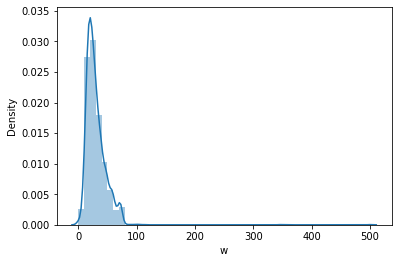

In [9]:
#check the distribution of wages
sns.distplot(df.w)

<AxesSubplot:xlabel='lnw', ylabel='Density'>

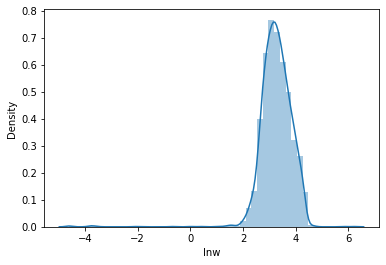

In [10]:
sns.distplot(df.lnw)

As distribution of wage is skewed, I would use ln(wage) as a dependent variable

In [11]:
def lnw_diff_by_variables2(df, factor_var, dummy_var, factor_lab, dummy_lab):
    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=("lnw", np.mean), sd=("lnw", np.std), size=("lnw", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1 / 2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()
    plot = (
        ggplot(
            stats,
            aes(
                stats.columns[0],
                stats.columns[2],
                fill="factor(" + stats.columns[1] + ")",
            ),
        )
        + geom_bar(stat="identity", position=position_dodge(width=0.9))
        + geom_errorbar(
            aes(ymin="Mean_l", ymax="Mean_u"),
            position=position_dodge(width=0.9),
            width=0.25,
        )
      #  + scale_color_manual(name=dummy_lab, values=("#3a5e8cFF", "#10a53dFF"))
      #  + scale_fill_manual(name=dummy_lab, values=("#3a5e8cFF", "#10a53dFF"))
        + ylab("Mean lnw")
        + xlab(factor_lab)
        + theme_bw()
        + theme(
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),
            axis_line=element_line(),
            legend_position="top",
            legend_box="vertical",
            legend_text=element_text(size=5),
            legend_title=element_text(size=5, face="bold"),
        )
    )

    return plot

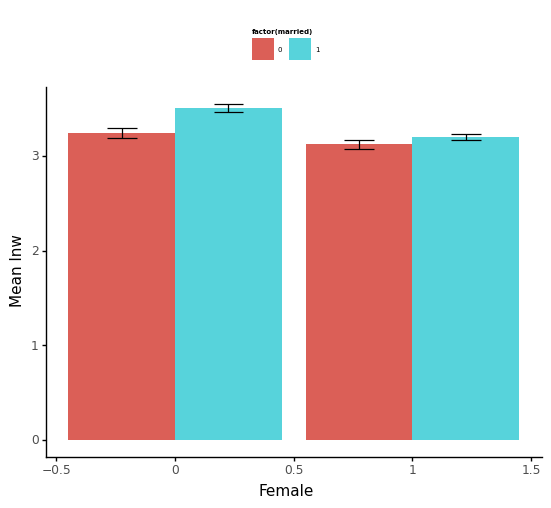

<ggplot: (166013627582)>

In [12]:
lnw_diff_by_variables2(df,"female","married","Female", "Married")

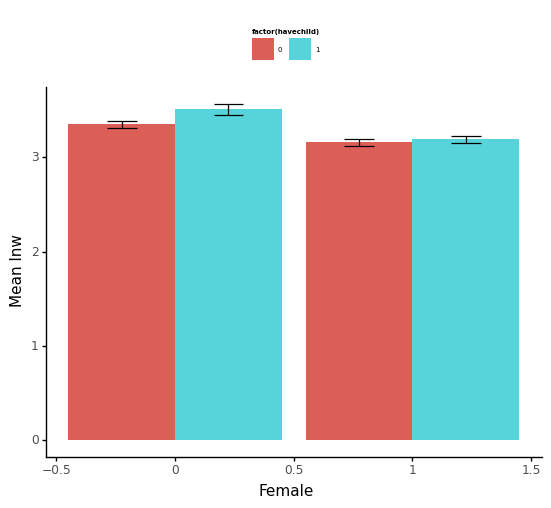

<ggplot: (166013690567)>

In [13]:
lnw_diff_by_variables2(df,"female","havechild","Female", "Have at least 1 child")

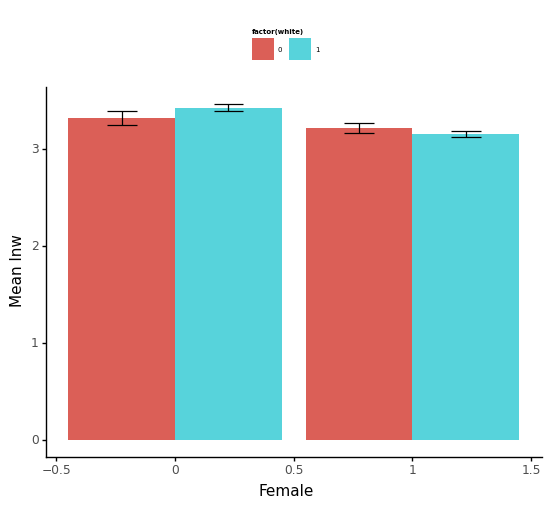

<ggplot: (166013688173)>

In [14]:
lnw_diff_by_variables2(df,"female","white","Female", "White")

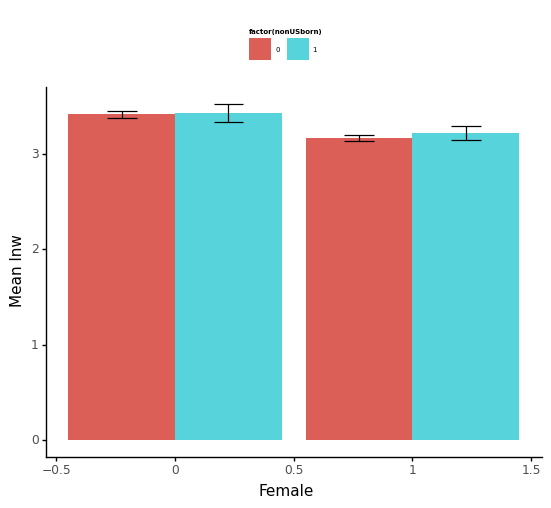

<ggplot: (166013749724)>

In [15]:
lnw_diff_by_variables2(df,"female","nonUSborn","Female", "Not born in the US")

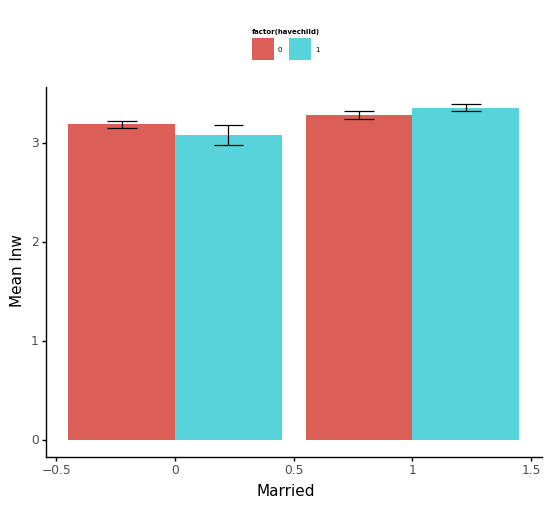

<ggplot: (166013754938)>

In [16]:
lnw_diff_by_variables2(df,"married","havechild","Married", "Have at least 1 child")

### Setting up models

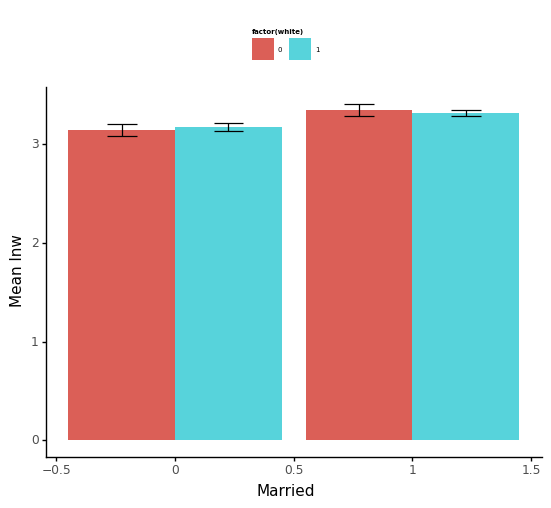

<ggplot: (166013907580)>

In [17]:
lnw_diff_by_variables2(df,"married","white","Married", "White")

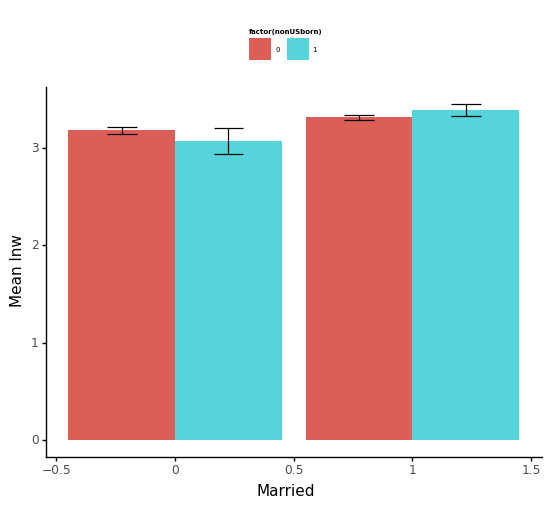

<ggplot: (166013874448)>

In [18]:
lnw_diff_by_variables2(df,"married","nonUSborn","Married", "Not born in the US")

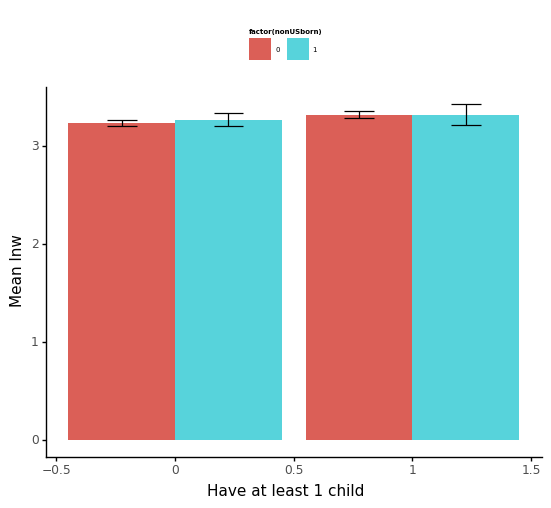

<ggplot: (166013908782)>

In [19]:
lnw_diff_by_variables2(df,"havechild","nonUSborn","Have at least 1 child", "Not born in the US")

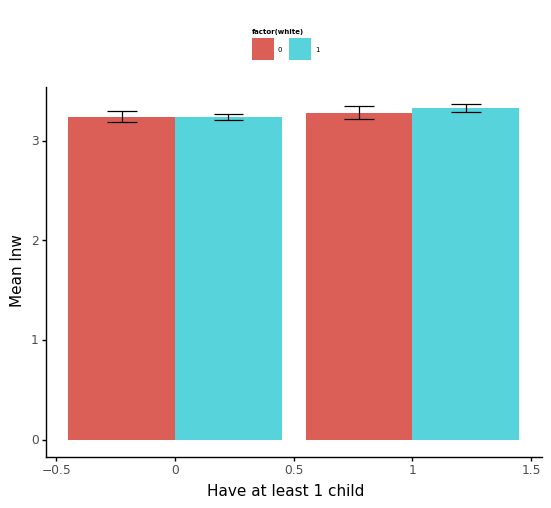

<ggplot: (166014109172)>

In [20]:
lnw_diff_by_variables2(df,"havechild","white","Have at least 1 child", "White")

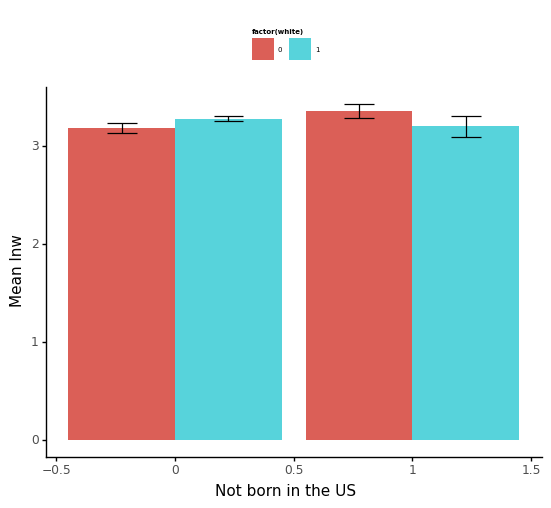

<ggplot: (166014154677)>

In [21]:
lnw_diff_by_variables2(df,"nonUSborn","white","Not born in the US", "White")

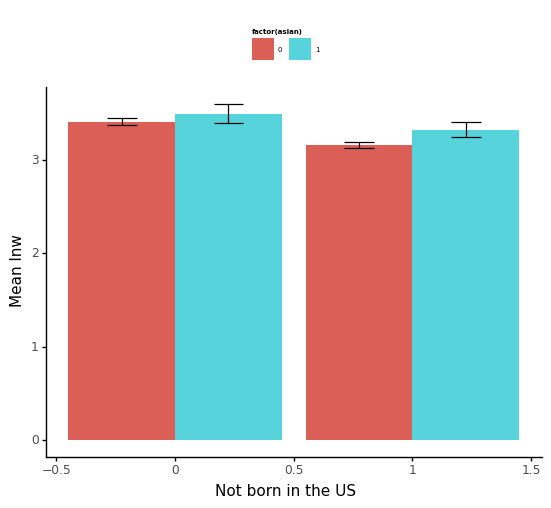

<ggplot: (166014879678)>

In [87]:
lnw_diff_by_variables2(df,"female","asian","Not born in the US", "White")

In [108]:
basic_lev = (
    "female",
    "age",
    "educ"
)
race_dummies = ("afram", "asian", "hisp", 'othernonw')
age_poly = ("agesq", "agecu")
educ_poly = ("educsq", "educcu")
other_variables = ("havechild", "nonUSborn")

# interactions suggested by graphs
X1=("female*married", "female*havechild", 
    "married*havechild", "married*nonUSborn",
    "havechild*nonUSborn")

# race interactions + not suggested by graphs
X2=("havechild*nonUSborn","female*nonUSborn",
    "afram*female","afram*married","afram*havechild","afram*nonUSborn",
    "asian*female","asian*married","asian*havechild","asian*nonUSborn",
    "hisp*female","hisp*married","hisp*havechild","hisp*nonUSborn",
    "othernonw*female","othernonw*married","othernonw*havechild","othernonw*nonUSborn")

In [109]:
modellev1="~"+"+".join(basic_lev)
modellev2="~"+"+".join(basic_lev)+"+"+"+".join(age_poly)+"+"+"+".join(educ_poly)
modellev3="~"+"+".join(basic_lev)+"+"+"+".join(age_poly)+"+"+"+".join(educ_poly)+"+"+"+".join(other_variables)+"+"+"+".join(X1)
modellev4="~"+"+".join(basic_lev)+"+"+"+".join(age_poly)+"+"+"+".join(educ_poly)+"+"+"+".join(other_variables)+"+"+"+".join(X1)+"+"+"+".join(X2)

### Separate hold-out set

In [110]:
#################################
# Separate hold-out set #
#################################
smp_size = round(0.2 * df.shape[0])-1

In [111]:
# Set the random number generator: It will make results reproducable
np.random.seed(20180123)

In [112]:
from sklearn.model_selection import train_test_split

In [113]:
data_work,data_holdout=train_test_split(df, test_size=smp_size)

### Cross validated RMSE

In [114]:
n_folds=5

In [115]:
from sklearn.model_selection import KFold
from statsmodels.tools.eval_measures import mse,rmse
k = KFold(n_splits=n_folds, shuffle=False, random_state=None)

In [116]:
def cv_reg(formula, data, kfold, testdata, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []
    rmse_list_test = []

    # Calculating OLS for each fold

    for train_index, test_index in k.split(data):
        # print("TRAIN:", train_index, "TEST:", test_index)
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data=data_train).fit()
        else:
            model = smf.ols(formula, data=data_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]

        rmse_tr = pd.concat(
            [data_train["lnw"], model.predict(data_train)],
            axis=1,
            keys=["lnw", "predicted"],
        )
        rmse_tr = rmse_tr[~rmse_tr.isna().any(axis=1)]

        rmse_te = pd.concat(
            [data_test["lnw"], model.predict(data_test)],
            axis=1,
            keys=["lnw", "predicted"],
        )
        rmse_te = rmse_te[~rmse_te.isna().any(axis=1)]

        rmse_list += [rmse(rmse_tr["lnw"], rmse_tr["predicted"], axis=0)]
        rmse_list_test += [rmse(rmse_te["lnw"], rmse_te["predicted"], axis=0)]
    nvars = model.df_model

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
        "rmse_test": rmse_list_test,
        "nvars": nvars,
    }


def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cvlist))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [117]:
cv_list = []
for i in [
    modellev1,
    modellev2,
    modellev3,
    modellev4,
]:
    cv_list += [cv_reg("lnw" + i, data_work, k, "HC0")]

In [118]:
summarize_cv(cv_list)

,Model1,Model2,Model3,Model4
Fold1,0.550254,0.544153,0.541837,0.538278
Fold2,0.564869,0.561989,0.558292,0.553196
Fold3,0.579014,0.574480,0.569703,0.566454
Fold4,0.607446,0.601821,0.598811,0.594415
Fold5,0.570803,0.566854,0.563494,0.558804
Average,0.574477,0.569860,0.566427,0.562230


In [119]:
# RMSE training vs test graph
rmse_levels = {"nvars": [], "var": [], "value": []}
for i in range(0, 4):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("RMSE Training")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse"]).mean())
for i in range(0, 4):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("RMSE Test")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse_test"]).mean())
rmse_levels = pd.DataFrame.from_dict(rmse_levels)
rmse_levels["nvars2"] = rmse_levels["nvars"] + 1

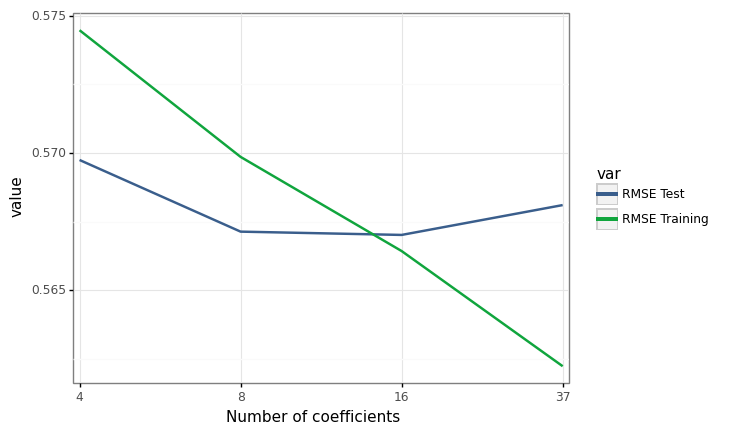

<ggplot: (166014696891)>

In [120]:
(
    ggplot(rmse_levels, aes(x="factor(nvars2)", y="value", color="var", group="var"))
    + geom_line(size=1, show_legend=True, na_rm=True)
    + scale_color_manual(name="", values=("#3a5e8cFF", "#10a53dFF"))
    #+ scale_y_continuous(name="RMSE", limits=(26, 50))#, breaks=seq(26, 50, 2))
    + scale_x_discrete(
        name="Number of coefficients",
        expand=(0.01, 0.01)
        # ) + geom_dl(aes(label = var),  method = list("last.points", dl.trans(x=x-1), cex=0.4)
    )
    + theme_bw()
)

In [121]:
results = summarize_cv(cv_list).T
results.rename(
    columns={
        "Average": "CV RMSE",
    },
    inplace=True,
)
results = results[["CV RMSE"]]
results

,CV RMSE
Model1,0.574477
Model2,0.569860
Model3,0.566427
Model4,0.562230


#### Cross-validated RMSE suggests that the model 4 has a better performance

### BIC in the full sample

In [122]:
reg1 = smf.ols(formula="lnw" + modellev1, data=df).fit(cov_type="HC1")
reg2 = smf.ols(formula="lnw" + modellev2, data=df).fit(cov_type="HC1")
reg3 = smf.ols(formula="lnw" + modellev3, data=df).fit(cov_type="HC1")
reg4 = smf.ols(formula="lnw" + modellev4, data=df).fit(cov_type="HC1")

In [123]:
bic_results = [reg1.bic , reg2.bic, reg3.bic, reg4.bic]
results["BIC"] = bic_results

In [124]:
results

,CV RMSE,BIC
Model1,0.574477,6087.424893
Model2,0.569860,6058.663258
Model3,0.566427,6100.126478
Model4,0.562230,6234.398213


#### BIC suggests that the model 2 has the best performance.

### RMSE in the full sample

In [125]:
RMSE_results = [rmse(df["lnw"],reg1.predict()),
                rmse(df["lnw"],reg2.predict()),
                rmse(df["lnw"],reg3.predict()),
                rmse(df["lnw"],reg4.predict())]
results["RMSE"] = RMSE_results

In [126]:
results

,CV RMSE,BIC,RMSE
Model1,0.574477,6087.424893,0.588864
Model2,0.569860,6058.663258,0.583587
Model3,0.566427,6100.126478,0.581567
Model4,0.562230,6234.398213,0.578456


#### RMSE suggests that the model 4 has the best performance

### Results

In [127]:
results

,CV RMSE,BIC,RMSE
Model1,0.574477,6087.424893,0.588864
Model2,0.569860,6058.663258,0.583587
Model3,0.566427,6100.126478,0.581567
Model4,0.562230,6234.398213,0.578456


#### Cross validated RMSE and RMSE suggest that the last model has the best performance whereas BIC suggests that the model 2 has the best performance